In [54]:
"""
Author: Ryan Quirk, Huntley Hedrick, Matthew Griffith
Files: Analysis.ipynb, BCHAIN-MKPRU.csv, LBMA-GOLD.csv
Project Description: 

"""


# Clean data
# Maybe measure volatiltity
# Covariance, variance, and correlation

'\nAuthor: Ryan Quirk, Huntley Hedrick, Matthew Griffith\nFiles: Analysis.ipynb, BCHAIN-MKPRU.csv, LBMA-GOLD.csv\nProject Description: \n\n'

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime, timedelta


gold_df = pd.read_csv("LBMA-GOLD.csv")
bcoin_df = pd.read_csv("BCHAIN-MKPRU.csv")

gold_df.describe()
gold_df.head()

,Date,Value1
0,9/12/2016,1324.60
1,9/13/2016,1323.65
2,9/14/2016,1321.75
3,9/15/2016,1310.80
4,9/16/2016,1308.35


In [56]:
bcoin_df.describe()
bcoin_df.head()


,Date,Value
0,9/11/16,621.65
1,9/12/16,609.67
2,9/13/16,610.92
3,9/14/16,608.82
4,9/15/16,610.38


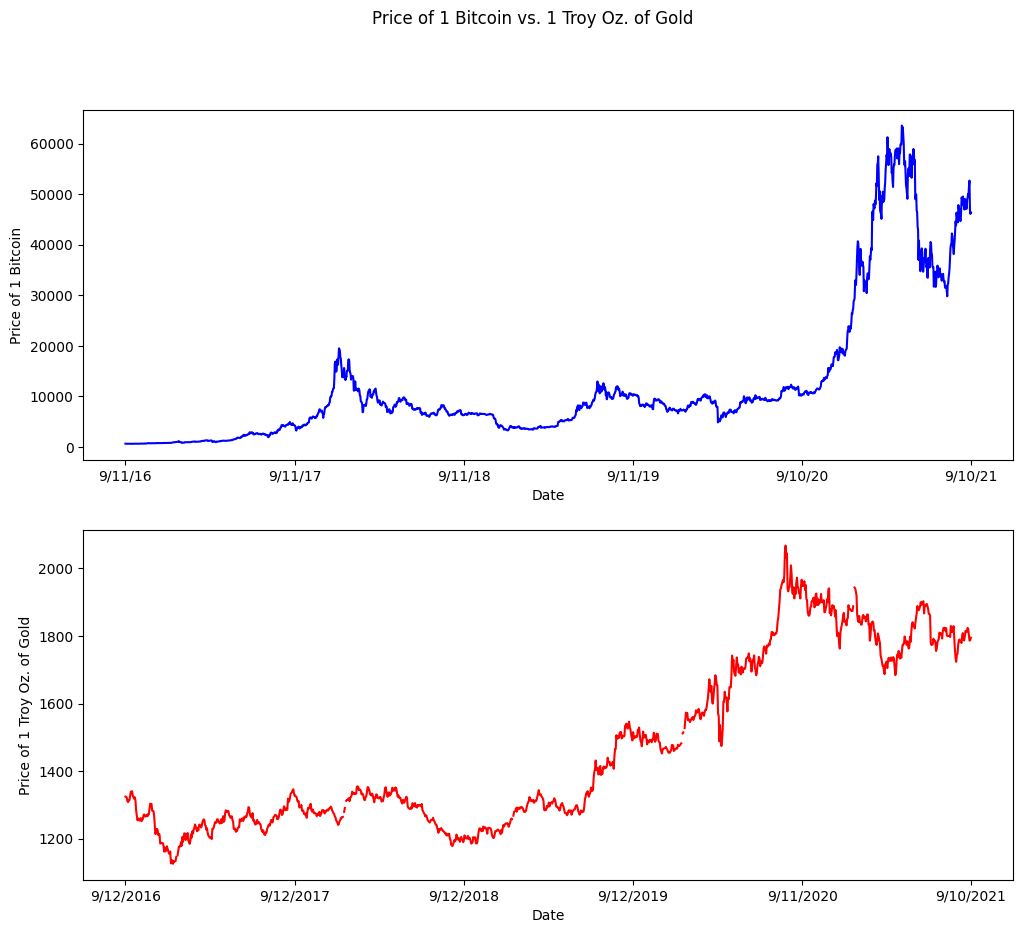

In [57]:

b_xtcks = [bcoin_df["Date"][0], bcoin_df["Date"][365], bcoin_df["Date"][730], bcoin_df["Date"][1095], bcoin_df["Date"][1460], bcoin_df["Date"][1825]]
g_xtcks = [gold_df["Date"][0], gold_df["Date"][253], gold_df["Date"][506], gold_df["Date"][759], gold_df["Date"][1012], gold_df["Date"][1264]]

figure, axis = plt.subplots(2,1)
figure.set_figwidth(12)
figure.set_figheight(10)

# Bitcoin plot
axis[0].plot(bcoin_df["Date"], bcoin_df["Value"], color='b')
axis[0].set_xticks(b_xtcks)
axis[0].set_xlabel("Date")
axis[0].set_ylabel("Price of 1 Bitcoin")

# Gold plot
axis[1].plot(gold_df["Date"], gold_df["Value1"], color='r')
axis[1].set_xticks(g_xtcks)
axis[1].set_xlabel("Date")
axis[1].set_ylabel("Price of 1 Troy Oz. of Gold")

figure.suptitle("Price of 1 Bitcoin vs. 1 Troy Oz. of Gold")
plt.show()



C:\Users\mg416\AppData\Local\Temp\ipykernel_54116\2098135133.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bcoin_df["Date"] = pd.to_datetime(bcoin_df["Date"])


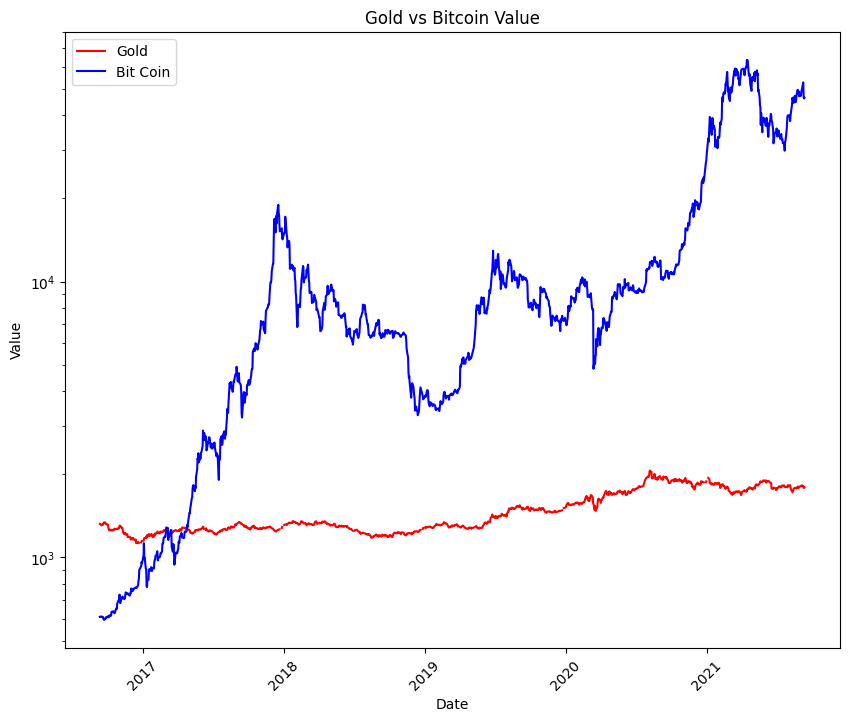

In [58]:
gold_df["Date"] = pd.to_datetime(gold_df["Date"])
bcoin_df["Date"] = pd.to_datetime(bcoin_df["Date"])

merged_df = pd.merge(gold_df[['Date', 'Value1']], bcoin_df[['Date', 'Value']], on='Date', how='inner')


plt.figure(figsize=(10,8))
plt.plot(merged_df['Date'], merged_df['Value1'], color='r', label='Gold')
plt.plot(merged_df['Date'], merged_df['Value'], color='b', label='Bit Coin')
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("Gold vs Bitcoin Value")
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels if needed for better readability
plt.yscale('log')
plt.show()

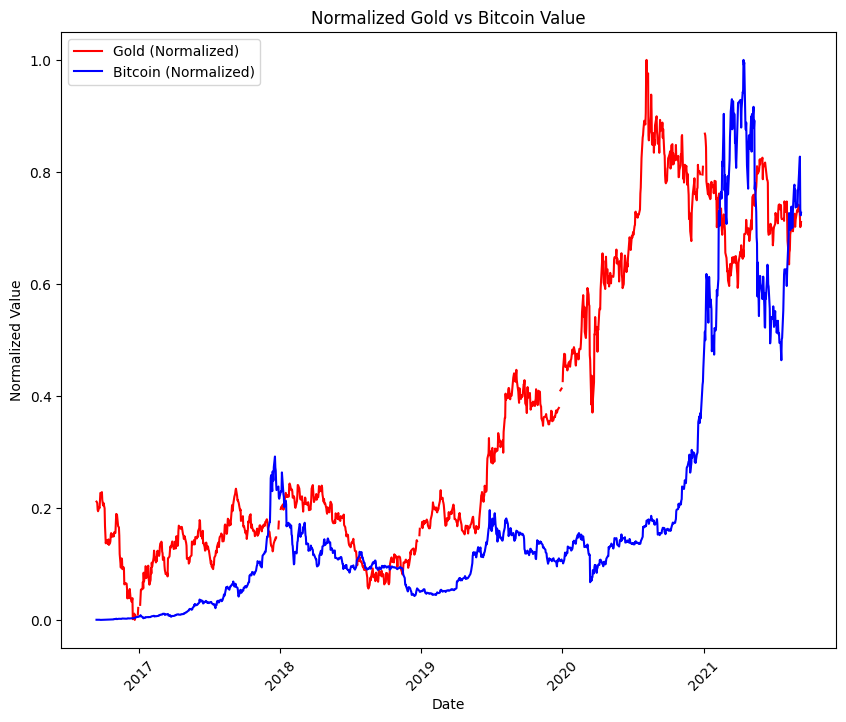

In [59]:
gold_normalized = (merged_df["Value1"] - merged_df["Value1"].min()) / (merged_df["Value1"].max() - merged_df["Value1"].min())
bcoin_normalized = (merged_df["Value"] - merged_df["Value"].min()) / (merged_df["Value"].max() - merged_df["Value"].min())

# Plot the normalized values
plt.figure(figsize=(10,8))
plt.plot(merged_df["Date"], gold_normalized, color='r', label='Gold (Normalized)')
plt.plot(merged_df["Date"], bcoin_normalized, color='b', label='Bitcoin (Normalized)')
plt.xlabel("Date")
plt.ylabel("Normalized Value")
plt.title("Normalized Gold vs Bitcoin Value")
plt.legend()
plt.xticks(rotation=45)
plt.show()

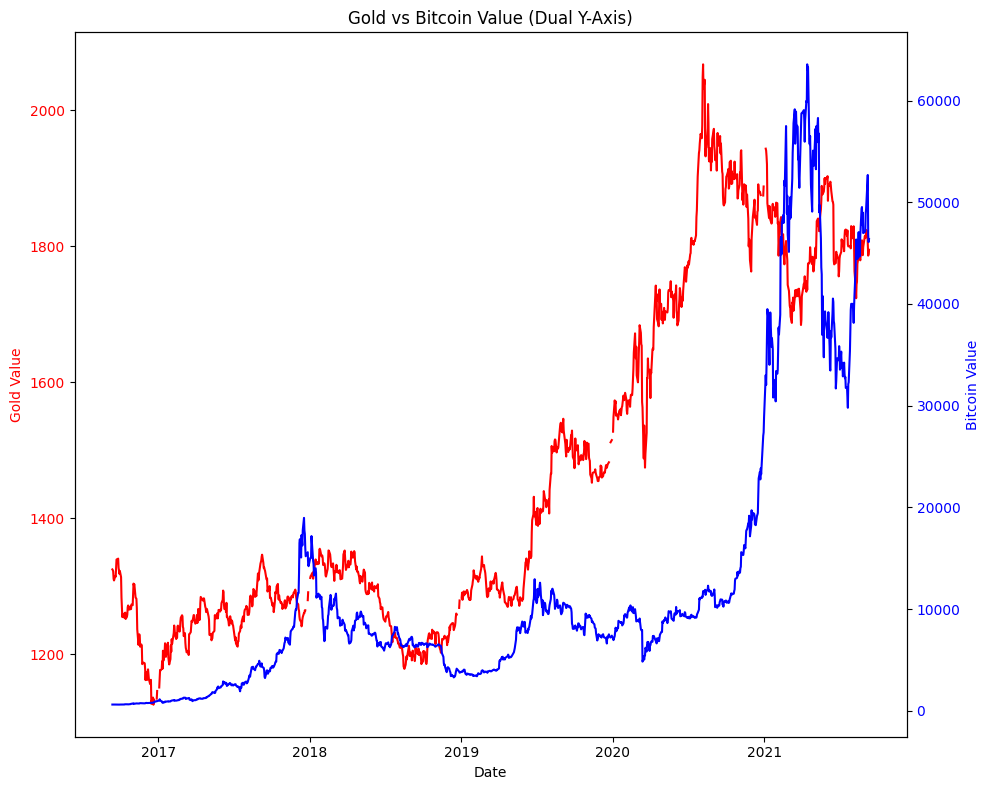

In [60]:
fig, ax1 = plt.subplots(figsize=(10,8))

# Plot Gold on the first y-axis
ax1.plot(merged_df["Date"], merged_df["Value1"], color='r', label='Gold')
ax1.set_xlabel("Date")
ax1.set_ylabel("Gold Value", color='r')
ax1.tick_params(axis='y', labelcolor='r')

# Create a second y-axis to plot Bitcoin
ax2 = ax1.twinx()
ax2.plot(merged_df["Date"], merged_df["Value"], color='b', label='Bitcoin')
ax2.set_ylabel("Bitcoin Value", color='b')
ax2.tick_params(axis='y', labelcolor='b')

plt.title("Gold vs Bitcoin Value (Dual Y-Axis)")
plt.xticks(rotation=45)
fig.tight_layout()
plt.show()

In [61]:
merged_df = merged_df.dropna(subset=['Value1', 'Value'])

all_data = np.stack((merged_df['Value1'], merged_df['Value']), axis=0)

corr_gd_bc = np.corrcoef(all_data)[0,1]
print(corr_gd_bc)

0.6494709842626689


In [67]:
from sklearn.impute import SimpleImputer

# Define the imputer to fill missing values with the mean
imputer = SimpleImputer(strategy='mean')
model = LinearRegression()

# Prepare the training data (ensure merged_df is preprocessed)
train_features = merged_df[['Value1', 'Value']].copy()

# Create lag features and rolling averages for training
train_features['gold_price_lag1'] = train_features['Value1'].shift(1)
train_features['bcoin_price_lag1'] = train_features['Value'].shift(1)
train_features['gold_ma3'] = train_features['Value1'].rolling(window=3).mean()
train_features['bcoin_ma3'] = train_features['Value'].rolling(window=3).mean()

# Drop rows with NaN values after feature engineering
train_features = train_features.dropna()

# Prepare the target variable (predicting 'Value1' as the gold price)
train_target = train_features['Value1']

# Fit the Linear Regression model
model.fit(train_features[['gold_price_lag1', 'bcoin_price_lag1', 'gold_ma3', 'bcoin_ma3']], train_target)

# Fit the imputer on the training features
imputer.fit(train_features[['gold_price_lag1', 'bcoin_price_lag1', 'gold_ma3', 'bcoin_ma3']])

# Generate future dates
last_date = pd.to_datetime(gold_df['Date'].iloc[-1])  # Last date in your dataset
num_days = 20  # Number of future days to predict
future_dates = [last_date + pd.Timedelta(days=i) for i in range(1, num_days + 1)]

# Create a DataFrame to store future predictions
future_data = merged_df.copy()
predicted_prices = []

# Predict each future day iteratively
for date in future_dates:
    # Create lagged features for prediction
    gold_price_lag1 = future_data['Value1'].iloc[-1]
    bcoin_price_lag1 = future_data['Value'].iloc[-1]
    
    # Calculate rolling means safely
    gold_ma3 = future_data['Value1'].rolling(window=3).mean().iloc[-1] if len(future_data) >= 3 else gold_price_lag1
    bcoin_ma3 = future_data['Value'].rolling(window=3).mean().iloc[-1] if len(future_data) >= 3 else bcoin_price_lag1
    
    # Prepare input for the model
    future_features = pd.DataFrame({
        'gold_price_lag1': [gold_price_lag1],
        'bcoin_price_lag1': [bcoin_price_lag1],
        'gold_ma3': [gold_ma3],
        'bcoin_ma3': [bcoin_ma3]
    })

    # Impute missing values in future_features if any NaNs exist
    future_features = imputer.transform(future_features)

    # Predict gold price
    future_gold_price = model.predict(future_features)[0]
    predicted_prices.append(future_gold_price)
    
    # Update future_data to include the new prediction (to calculate rolling features)
    future_data = pd.concat([
        future_data,
        pd.DataFrame({'Date': [date], 'Value1': [future_gold_price], 'Value': [bcoin_price_lag1]})
    ], ignore_index=True)

# Create a DataFrame for future predictions
future_predictions = pd.DataFrame({
    'Date': future_dates,
    'Predicted_Gold_Price': predicted_prices
})

# Display future predictions
print(future_predictions)


         Date  Predicted_Gold_Price
0  2021-09-11           1787.135450
1  2021-09-12           1791.413375
2  2021-09-13           1790.873271
3  2021-09-14           1789.277886
4  2021-09-15           1791.148691
5  2021-09-16           1790.080095
6  2021-09-17           1790.217715
7  2021-09-18           1790.619342
8  2021-09-19           1790.153383
9  2021-09-20           1790.423223
10 2021-09-21           1790.391083
11 2021-09-22           1790.292896
12 2021-09-23           1790.411867
13 2021-09-24           1790.346653
14 2021-09-25           1790.357042
15 2021-09-26           1790.383956
16 2021-09-27           1790.356516
17 2021-09-28           1790.375184
18 2021-09-29           1790.374925
19 2021-09-30           1790.370534


c:\Users\mg416\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mg416\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mg416\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mg416\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
c:\Users\mg416\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but Line

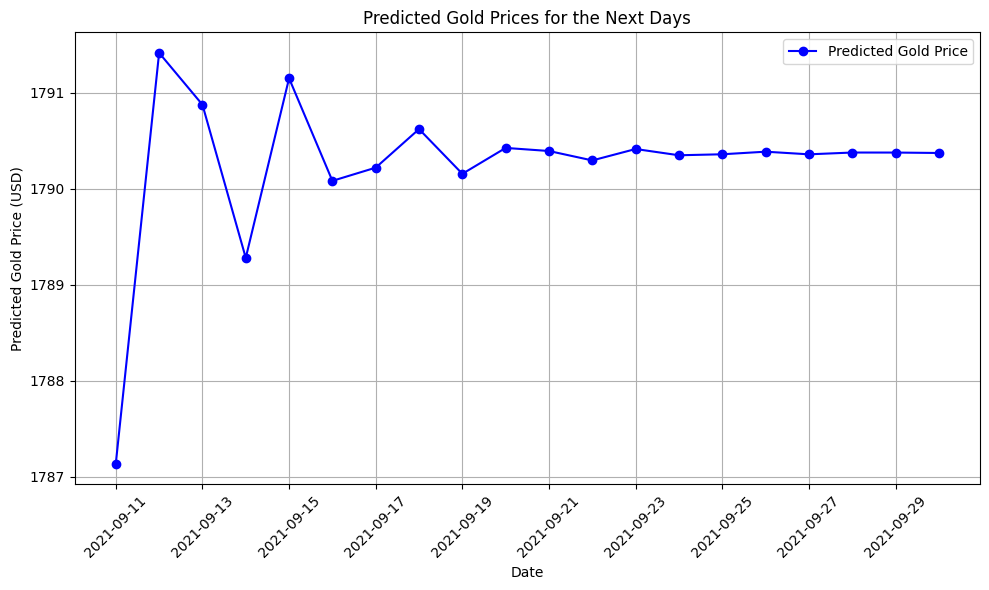

In [68]:
plt.figure(figsize=(10, 6))
plt.plot(future_predictions['Date'], future_predictions['Predicted_Gold_Price'], marker='o', color='b', label='Predicted Gold Price')

plt.title('Predicted Gold Prices for the Next Days')
plt.xlabel('Date')
plt.ylabel('Predicted Gold Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

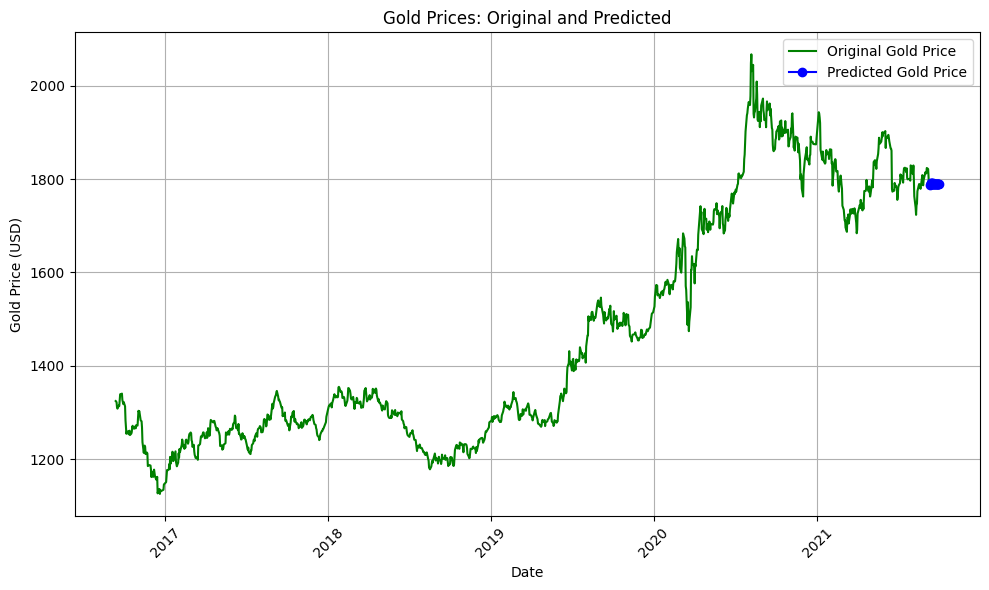

In [69]:
filtered_data = merged_df[merged_df['Date'] <= '2021-09-10']

plt.figure(figsize=(10, 6))

# Plot original values (using the 'Value1' column for gold prices)
plt.plot(filtered_data['Date'], filtered_data['Value1'], label='Original Gold Price', color='g')

# Plot predicted values for the future
plt.plot(future_predictions['Date'], future_predictions['Predicted_Gold_Price'], marker='o', label='Predicted Gold Price', color='b')

plt.title('Gold Prices: Original and Predicted')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

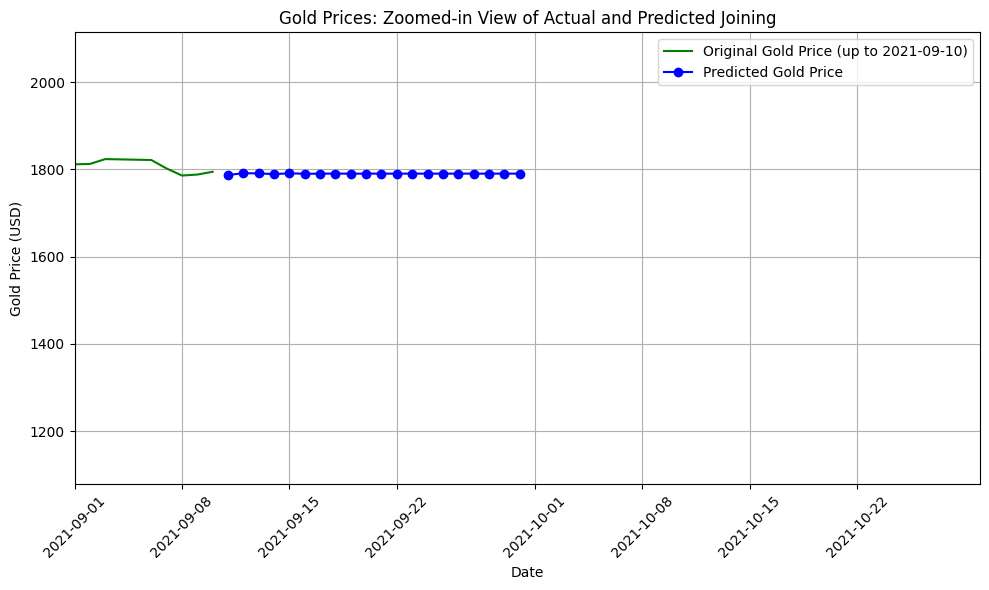

In [70]:
zoom_start = '2021-09-01'
zoom_end = '2021-10-30'

plt.figure(figsize=(10, 6))

# Plot filtered original data (up to 2021-08-04)
plt.plot(filtered_data['Date'], filtered_data['Value1'], label='Original Gold Price (up to 2021-09-10)', color='g')

# Plot predicted values for the future
plt.plot(future_predictions['Date'], future_predictions['Predicted_Gold_Price'], marker='o', label='Predicted Gold Price', color='b')

# Add x-axis limits to zoom in on the joining area
plt.xlim(pd.to_datetime(zoom_start), pd.to_datetime(zoom_end))

plt.title('Gold Prices: Zoomed-in View of Actual and Predicted Joining')
plt.xlabel('Date')
plt.ylabel('Gold Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()